In [30]:
from PIL import Image
import requests
import io
import mercantile
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import numpy as np
import overpy
import json
import geojson
import overpass
from osmtogeojson import osmtogeojson
from shapely.geometry import shape
from shapely.geometry import Point


In [ ]:
# Download the following file from https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files or similar
shapefile_path = "../data/SA1_2021_AUST_SHP_GDA2020/SA1_2021_AUST_GDA2020.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.crs)

# getting NSW only SA1 polygons
nsw_gdf = gdf[gdf["STE_CODE21"] == "1"]
nsw_gdf['xmin'] = nsw_gdf['geometry'].bounds['minx']
nsw_gdf['ymin'] = nsw_gdf['geometry'].bounds['miny']
nsw_gdf['xmax'] = nsw_gdf['geometry'].bounds['maxx']
nsw_gdf['ymax'] = nsw_gdf['geometry'].bounds['maxy']

nsw_gdf = nsw_gdf[['SA1_CODE21', 'xmin', 'ymin', 'xmax', 'ymax', 'geometry']]
# nsw_gdf.to_csv("nsw_gdf.csv")

In [20]:
# extract a chatswood SA1 for testing
chatswood_sa1_gdf = nsw_gdf[nsw_gdf['SA1_CODE21'] == '12101168412']

In [21]:
class TileImage:
    def __init__(self, url=None, level=None, row=None, column=None):
        """
        Initialize a TileImage object.

        Parameters:
        - url (str, optional): URL or file path of the image.
        - level (int, optional): Level of the image.
        - row (int, optional): Row position of the image.
        - column (int, optional): Column position of the image.
        - image (bytes, optional): Bytes representing the image.
        - x (int, optional): X-coordinate of the image in the final grid.
        - y (int, optional): Y-coordinate of the image in the final grid.
        """
        self.url = url
        self.level = level
        self.row = row
        self.column = column
        self.image = None
        self.x = None
        self.y = None
        self.size = None

    def download_image(self):
        if not self.url:
            return

        params = {
            'blankTile': 'false',
        }
        response = requests.get(self.url, params=params)
        if response.status_code == 200:
            image_bytes = response.content
            self.image = image_bytes
            self.size = Image.open(io.BytesIO(image_bytes)).size
        else:
            print(f"Request failed with status code {response.status_code} for {self.url}")

class SA1Image:
    base_url = "https://maps.six.nsw.gov.au/arcgis/rest/services/sixmaps/LPI_Imagery_Best/MapServer/"

    def __init__(self, sa1_gdf, zoom_level:int):
        """
        Args:
            SA1code (str): code for SA1
            zoom_level (int): zoom level
            bbox (list[float]): SA1 polygon bounding box coordinates [xmin, ymin, xmax, ymax]
        """
        self.SA1code = sa1_gdf.iloc[0]['SA1_CODE21']
        self.SA1_bbox = [sa1_gdf.iloc[0]['xmin'], sa1_gdf.iloc[0]['ymin'], sa1_gdf.iloc[0]['xmax'], sa1_gdf.iloc[0]['ymax']]  # this bbox touches the SA1 polgon edges
        self.zoom_level = zoom_level
        self.polygon = sa1_gdf
        self.tile_images = self.download_tile_images()
        self.tiles_bbox = self.calculate_bounding_box()  # this bbox is the bbox for the final image, which should be larger than self.SA1_bbox
        self.row_count = max(self.tile_images, key=lambda x: x.y).y + 1  # calculate the grid coordinates of stitched images
        self.col_count = max(self.tile_images, key=lambda x: x.x).x + 1
        self.image = self.stitch_images()

    def download_tile_images(self):
        tiles = list(mercantile.tiles(*self.SA1_bbox, self.zoom_level))
        tile_images = []

        for tile in tiles:
            print(f"Zoom Level: {self.zoom_level}, Column (X): {tile.x}, Row (Y): {tile.y}")
            url = f'{SA1Image.base_url}/tile/{self.zoom_level}/{tile.y}/{tile.x}'
            tile_image = TileImage(url=url, level=self.zoom_level, row=tile.y, column=tile.x)
            tile_image.download_image()
            tile_images.append(tile_image)

        #  calculate where each tile should be placed in the final grid
        smallest_row = min(tile_images, key=lambda x: x.row).row
        smallest_column = min(tile_images, key=lambda x: x.column).column

        for tile_image in tile_images:
            tile_image.x = tile_image.column - smallest_column
            tile_image.y = tile_image.row - smallest_row
            
        return tile_images

    def calculate_bounding_box(self):  # extent coordinates for matplotlib
        if not self.tile_images:
            return None

        top_left_tile = next((tile for tile in self.tile_images if tile.x == 0 and tile.y == 0), None)
        bottom_right_tile = max(self.tile_images, key=lambda tile: (tile.x, tile.y), default=None)

        ul_coordinates = mercantile.ul(top_left_tile.column, top_left_tile.row, top_left_tile.level)
        top_left_lat, top_left_lng = ul_coordinates.lat, ul_coordinates.lng

        bottom_right_tile = mercantile.bounds(bottom_right_tile.column, bottom_right_tile.row, top_left_tile.level)
        bottom_right_lng, bottom_right_lat = bottom_right_tile.east, bottom_right_tile.south

        return [top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat]

    def stitch_images(self) -> Image.Image:
        if not self.tile_images:
            return None

        # Find dimensions of the final image based on the maximum x and y coordinates in the grid
        max_x = max(tile.x for tile in self.tile_images)
        max_y = max(tile.y for tile in self.tile_images)

        tile_width, tile_height = self.tile_images[0].size

        # Calculate the actual dimensions of the final image based on the grid.
        final_width = (max_x + 1) * tile_width
        final_height = (max_y + 1) * tile_height

        # Create an empty image with the calculated dimensions.
        final_image = Image.new('RGB', (final_width, final_height))

        # Paste each tile image onto the final image based on its grid coordinates.
        for tile in self.tile_images:
            if tile.image:
                tile_image = Image.open(io.BytesIO(tile.image))
                paste_x = tile.x * tile_width
                paste_y = tile.y * tile_height
                final_image.paste(tile_image, (paste_x, paste_y))

        return final_image

    def plot(self):
        fig, ax = plt.subplots()

        ax.imshow(self.image, extent=self.tiles_bbox)

        self.polygon.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
        plt.show()
        
    def save_as_geotiff(self):
        width, height = self.image.size

        # Replace lon1, lon2, lat1, lat2 with the left side, right side, bottom side, top side bbox coordinates of the area
        # top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat
        lon1, lon2, lat1, lat2 = self.tiles_bbox

        # Calculate the pixel width and pixel height
        pixel_width = (lon2 - lon1) / width
        pixel_height = (lat1 - lat2) / height

        print("pixel_width", pixel_width, "pixel_height", pixel_height)

        crs = rasterio.crs.CRS.from_epsg(7844)
        transform = from_origin(lon1, lat2, pixel_width, -pixel_height)  

        image_array = np.array(self.image)

        height, width, _ = image_array.shape

        # Create a GeoTIFF file and write the image array to it
        with rasterio.open(f'{self.SA1code}.tif', 'w', driver='GTiff', width=width, height=height, crs=crs, transform=transform, dtype=image_array.dtype, count=image_array.shape[2]) as dst:
            for i in range(image_array.shape[2]):
                dst.write(image_array[:, :, i], i + 1)

In [22]:
chatswood_sa1_image = SA1Image(chatswood_sa1_gdf, 18)

Zoom Level: 18, Column (X): 241162, Row (Y): 157246
Zoom Level: 18, Column (X): 241162, Row (Y): 157247
Zoom Level: 18, Column (X): 241162, Row (Y): 157248
Zoom Level: 18, Column (X): 241162, Row (Y): 157249
Zoom Level: 18, Column (X): 241163, Row (Y): 157246
Zoom Level: 18, Column (X): 241163, Row (Y): 157247
Zoom Level: 18, Column (X): 241163, Row (Y): 157248
Zoom Level: 18, Column (X): 241163, Row (Y): 157249
Zoom Level: 18, Column (X): 241164, Row (Y): 157246
Zoom Level: 18, Column (X): 241164, Row (Y): 157247
Zoom Level: 18, Column (X): 241164, Row (Y): 157248
Zoom Level: 18, Column (X): 241164, Row (Y): 157249
Zoom Level: 18, Column (X): 241165, Row (Y): 157246
Zoom Level: 18, Column (X): 241165, Row (Y): 157247
Zoom Level: 18, Column (X): 241165, Row (Y): 157248
Zoom Level: 18, Column (X): 241165, Row (Y): 157249
Zoom Level: 18, Column (X): 241166, Row (Y): 157246
Zoom Level: 18, Column (X): 241166, Row (Y): 157247
Zoom Level: 18, Column (X): 241166, Row (Y): 157248
Zoom Level: 

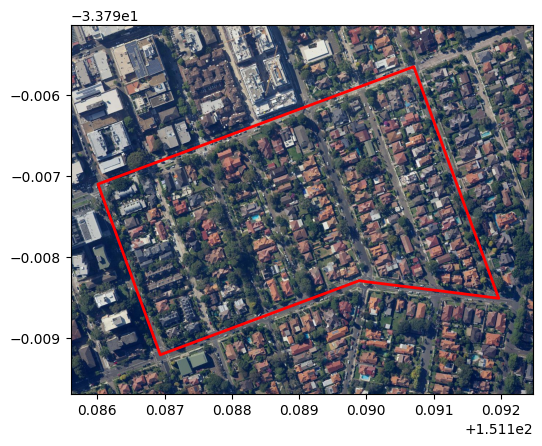

In [23]:
chatswood_sa1_image.plot()

In [24]:
chatswood_sa1_image.save_as_geotiff()

pixel_width 5.364418029785156e-06 pixel_height -4.457883026387499e-06


In [34]:
# Get building annotations from OSM for a specific SA1 area
sa1bbox = chatswood_sa1_image.SA1_bbox
api = overpass.API()
# -33.80627058022732,151.17650985717773,-33.79785455471434,151.18669152259827
query = f"""
[out:json];
(
way["building"]({sa1bbox[1]},{sa1bbox[0]},{sa1bbox[3]},{sa1bbox[2]});
relation["building"]["type"="multipolygon"]({sa1bbox[1]},{sa1bbox[0]},{sa1bbox[3]},{sa1bbox[2]});
);
out;
>;
out qt;
"""
print(query)
# res = api.get(query)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})

result = osmtogeojson.process_osm_json(r.json())

features = []

for feature in result['features']:
    geometry = shape(feature['geometry'])
    properties = feature['properties']
    features.append({'geometry': geometry, **properties})

osm_gdf = gpd.GeoDataFrame(features)

# Perform a spatial join to find polygons in 'osm_gdf' that intersect with 'chatswood_sa1_gdf'
buildings_within_sa1 = gpd.sjoin(osm_gdf, chatswood_sa1_gdf, how='inner', op='intersects')
buildings_within_sa1.crs = chatswood_sa1_gdf.crs
buildings_within_sa1 = buildings_within_sa1.drop(columns=['index_right'])
# 'buildings_within_sa1' now contains the polygons from 'osm_gdf' that intersect with 'chatswood_sa1_gdf'
buildings_within_sa1.to_file(f"buildings_within_sa1_{chatswood_sa1_image.SA1code}.geojson", driver="GeoJSON")


[out:json];
(
way["building"](-33.79920569428281,151.18601115274421,-33.79564731460931,151.191967001706);
relation["building"]["type"="multipolygon"](-33.79920569428281,151.18601115274421,-33.79564731460931,151.191967001706);
);
out;
>;
out qt;



/Users/xluo3503/opt/anaconda3/envs/aerial-ann/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/qf/wv928d816v5b2vwmwvfr6s8m0000gq/T/ipykernel_93212/2208562306.py:33: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:7844

  buildings_within_sa1 = gpd.sjoin(osm_gdf, chatswood_sa1_gdf, how='inner', op='intersects')


In [ ]:
# Test area
# Calculate and sum up the areas for the first GeoDataFrame
total_area_buildings_within_sa1 = buildings_within_sa1['geometry'].area.sum()

# Calculate and sum up the areas for the second GeoDataFrame
total_area_chatswood_sa1_gdf = chatswood_sa1_gdf['geometry'].area.sum()

print("total_area_buildings_within_sa1", total_area_buildings_within_sa1)
print("total_area_chatswood_sa1_gdf", total_area_chatswood_sa1_gdf)
print(f"{(total_area_buildings_within_sa1/total_area_chatswood_sa1_gdf)*100:.4f}%")

In [ ]:
# Test evenly spaced points
# Extract the polygon from the GeoDataFrame
polygon = chatswood_sa1_gdf['geometry'].iloc[0]

# Calculate the spacing based on the size of the polygon
minx, miny, maxx, maxy = polygon.bounds
x_range = maxx - minx
y_range = maxy - miny
print(x_range, y_range, x_range * y_range * 10**5)

# Define the number of points you want
num_points = x_range * y_range * 10**5 * 100 # TODO this should be a function based on the ranges

# Calculate spacing based on desired point density
desired_density = num_points / (x_range * y_range)
spacing = np.sqrt(1 / desired_density)  # Adjust as needed

# Create evenly spaced points within the polygon
x_coords = np.arange(minx, maxx, spacing)
y_coords = np.arange(miny, maxy, spacing)

points = []
for x in x_coords:
    for y in y_coords:
        point = Point(x, y)
        if polygon.contains(point):
            points.append(point)

# Create a GeoDataFrame from the points
points_gdf = gpd.GeoDataFrame(geometry=points, crs=chatswood_sa1_gdf.crs)

# Define the output GeoJSON file path
output_geojson_file = f'points_within_{chatswood_sa1_image.SA1code}_low_density.geojson'

# Write the GeoDataFrame to a GeoJSON file
points_gdf.to_file(output_geojson_file, driver='GeoJSON')

print(f"Points GeoDataFrame with reduced density saved to {output_geojson_file}")

# Create a copy of buildings_within_sa1 to work with
buildings_copy = buildings_within_sa1.copy()

# Check for intersection between points and building polygons
intersections = gpd.sjoin(points_gdf, buildings_copy, op='intersects')
intersections.to_file(f"intersections_points_{chatswood_sa1_image.SA1code}.geojson", driver='GeoJSON')
# To count the total number of points that are either within or intersect with building polygons,
# you can use the length of the 'intersections' GeoDataFrame:
total_count = len(intersections)

print("Total number of points within or intersecting with buildings:", total_count)
total_points_count = len(points_gdf)
print("Total number of points in points_gdf:", total_points_count)
print(f"ratio: {100*total_count/total_points_count:.4f}%")